In [127]:
import cv2
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import data
from tensorflow import keras
from keras.layers import CenterCrop, Lambda, Resizing
from keras.layers import BatchNormalization, Dense, Dropout, GlobalAveragePooling2D

import sys, os, time, random, pickle, warnings
from utils import ShowImage, ShowImages

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4'

In [128]:
print('[ Software/Library Version ]')
print(f'- Python     : {sys.version.split()[0]}')
print(f'- Numpy      : {np.__version__}')
print(f'- Matplotlib : {mpl.__version__}')
print(f'- OpenCV     : {cv2.__version__}')
print(f'- Pandas     : {pd.__version__}')
print(f'- Tensorflow : {tf.__version__}')

[ Software/Library Version ]
- Python     : 3.11.0
- Numpy      : 1.24.0
- Matplotlib : 3.10.1
- OpenCV     : 4.11.0
- Pandas     : 2.2.3
- Tensorflow : 2.14.0


# **1. Load Data**

## **1.1. Demographics Data**

In [129]:
DEMO_FILENAME = 'sample_data/demographics.csv'
df_demo = pd.read_csv(DEMO_FILENAME, index_col=0)
df_demo['sex'] = df_demo['sex'].map({'M': 0, 'F': 1})

df_demo

,sex,age,label
0,1,70,0
1,0,62,1


## **1.2. MRI Images (Cropped)**

In [130]:
X_test = np.zeros((len(df_demo), 224, 112, 3))

for pid in df_demo.index:
    for image_idx in range(3):
        image = cv2.imread(f'sample_data/case_{pid}/{image_idx}.png', cv2.IMREAD_GRAYSCALE)
        X_test[pid, :, :, image_idx] = image

X_test = X_test.astype(np.uint8)

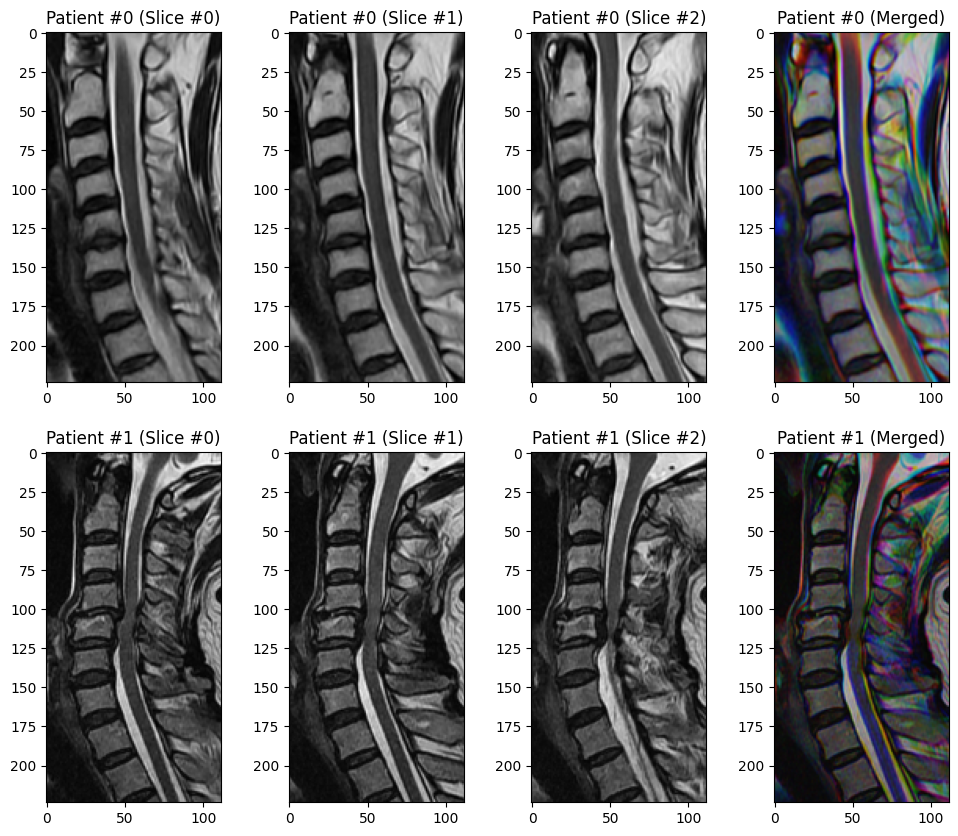

In [131]:
image_list = [
    X_test[0,:,:,0], X_test[0,:,:,1], X_test[0,:,:,2], X_test[0],
    X_test[1,:,:,0], X_test[1,:,:,1], X_test[1,:,:,2], X_test[1],
]
label_list = [
    'Patient #0 (Slice #0)', 'Patient #0 (Slice #1)', 'Patient #0 (Slice #2)', 'Patient #0 (Merged)',
    'Patient #1 (Slice #0)', 'Patient #1 (Slice #1)', 'Patient #1 (Slice #2)', 'Patient #1 (Merged)',
]

ShowImages(image_list, label_list, ncols=4, figsize=(3, 5))

# **2. Run Models**

## **2.1. Prepare `tf.data.Dataset` Object**

In [132]:
preprocess_image = tf.keras.Sequential([
    Lambda(lambda x: tf.cast(x, dtype=tf.float32)),
    CenterCrop(height=int(224 * 0.95), width=int(112 * 0.95)),
    Resizing(height=224, width=112)
])

def prepare_batch(ds):
    ds = ds.map(lambda X: preprocess_image(X))
    return ds.batch(16).prefetch(1)

ds_test = data.Dataset.from_tensor_slices(X_test)
ds_test = prepare_batch(ds_test)

## **2.2. Load Model by Architecture**

In [133]:
ARCH_LIST = ['ResNet50', 'VGG16', 'MobileNetV3', 'EfficientNetV2']

def load_model(arch, return_last_conv=False):
    # Load Backbone Model
    print(f'Loading [{arch}] Backbone Model...')

    if arch == 'ResNet50':
        backbone = keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')
    elif arch == 'VGG16':
        backbone = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet')
    elif arch == 'EfficientNetV2':
        backbone = keras.applications.efficientnet_v2.EfficientNetV2S(include_top=False, weights='imagenet')
    elif arch == 'MobileNetV3':
        backbone = keras.applications.MobileNetV3Large(include_top=False, weights='imagenet')

    # Add FF Layers
    hparams_arch = pickle.load(open(f'model/{arch}/hparams_arch.pkl', 'rb'))
    FF_LAYER_LIST = hparams_arch['FF_LAYER_LIST']
    DROPOUT_RATE = hparams_arch['DROPOUT_RATE']
    
    out = GlobalAveragePooling2D()(backbone.output)
    for n_node in FF_LAYER_LIST:
        out = Dropout(rate=DROPOUT_RATE, name=f'CustomDrop_{n_node}')(out)
        out = Dense(n_node, activation='relu', name=f'CustomFF_{n_node}')(out)
        out = BatchNormalization(name=f'CustomBN_{n_node}')(out)

    # Final Output
    out = Dropout(rate=DROPOUT_RATE, name='CustomDrop_final')(out)
    out = Dense(1, name='CustomFF_final')(out)

    # Define Model
    model = keras.Model(inputs=[backbone.input], outputs=[out])

    if return_last_conv:
        return model, backbone.layers[-1].name
    return model

## **2.3. Run Model**

In [134]:
def run_model(ds, arch):
    y_pred_proba_list = []
    
    model = load_model(arch)
    for i_fold in range(3):
        model.load_weights(f'model/{arch}/weights_{i_fold}.hdf5')
        
        y_pred_logit = model.predict(ds)
        y_pred_proba = tf.nn.sigmoid(y_pred_logit)
        y_pred_proba_list.append(y_pred_proba)

    y_pred_proba_list = np.array(y_pred_proba_list)
    y_pred_proba = np.mean(y_pred_proba_list, axis=0)
    
    print()
    return y_pred_proba

In [135]:
for arch in ARCH_LIST:
    y_pred_proba = run_model(ds_test, arch)
    df_demo[arch] = y_pred_proba

Loading [ResNet50] Backbone Model...
1/1 [==============================] - 0s 104ms/step

Loading [VGG16] Backbone Model...
1/1 [==============================] - 0s 97ms/step

Loading [MobileNetV3] Backbone Model...
1/1 [==============================] - 0s 58ms/step

Loading [EfficientNetV2] Backbone Model...
1/1 [==============================] - 0s 121ms/step



In [136]:
df_demo

,sex,age,label,ResNet50,VGG16,MobileNetV3,EfficientNetV2
0,1,70,0,0.078111,0.005461,0.074829,0.093921
1,0,62,1,0.984576,0.968956,0.969246,0.964624


## **2.4. Impact of Demographics**

In [137]:
LOGREG_FILENAME = {
    'age': 'model/Demographics_LogReg/log_reg__age__auc=0.9540.pkl',
    'sex': 'model/Demographics_LogReg/log_reg__sex__auc=0.9537.pkl',
    'age_sex': 'model/DemoGraphics_LogReg/log_reg__age_sex__auc=0.9537.pkl',
}

for demo_columns in [['age'], ['sex'], ['age', 'sex']]:
    demo_columns_str = '_'.join(demo_columns)

    logreg = pickle.load(open(LOGREG_FILENAME[demo_columns_str], 'rb'))
    y_proba_demo = logreg.predict(df_demo[ARCH_LIST + demo_columns])

    print(f'=== Prediction with {ARCH_LIST} + {demo_columns} ===')
    for i in range(len(df_demo)):
        print(f'Patient #{i}: {y_proba_demo[i]:.4f} (Ground Truth: {df_demo.loc[i, "label"]})')
    print()


=== Prediction with ['ResNet50', 'VGG16', 'MobileNetV3', 'EfficientNetV2'] + ['age'] ===
Patient #0: 0.0000 (Ground Truth: 0)
Patient #1: 1.0000 (Ground Truth: 1)

=== Prediction with ['ResNet50', 'VGG16', 'MobileNetV3', 'EfficientNetV2'] + ['sex'] ===
Patient #0: 0.0000 (Ground Truth: 0)
Patient #1: 1.0000 (Ground Truth: 1)

=== Prediction with ['ResNet50', 'VGG16', 'MobileNetV3', 'EfficientNetV2'] + ['age', 'sex'] ===
Patient #0: 0.0000 (Ground Truth: 0)
Patient #1: 1.0000 (Ground Truth: 1)



# **3. Grad-CAM**

In [138]:
def make_gradcam_heatmap(image, model, conv_layer_name, pred_idx=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_layer_out, preds = grad_model(image)
        
        if pred_idx  is None:
            pred_idx = tf.argmax(preds[0])
        class_channel = preds[:, pred_idx]

    grads = tape.gradient(class_channel, conv_layer_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_layer_out = conv_layer_out[0]
    heatmap = conv_layer_out @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) #/ tf.math.reduce_max(heatmap)
    return heatmap.numpy(), preds


def overlap_image_heatmap(image, heatmap, cmap='plasma', alpha=1):
    heatmap = np.abs(heatmap)
    heatmap = heatmap / np.max(heatmap)
    heatmap = np.uint8(heatmap * 255.)
    
    cmap = mpl.colormaps[cmap]
    cmap_colors = cmap(np.arange(256))[:, :3]
    cmap_heatmap = cmap_colors[heatmap]

    image = image / 255.
    image = (image + cmap_heatmap * alpha) / (1 + alpha)
    image = np.minimum(image, 1)
    return image

def sigmoid(z):
    return 1. / (1. + np.exp(-z))

>> Processing Patient #0...
Loading [ResNet50] Backbone Model...
Loading [VGG16] Backbone Model...
Loading [MobileNetV3] Backbone Model...
Loading [EfficientNetV2] Backbone Model...

>> Processing Patient #1...
Loading [ResNet50] Backbone Model...
Loading [VGG16] Backbone Model...
Loading [MobileNetV3] Backbone Model...
Loading [EfficientNetV2] Backbone Model...



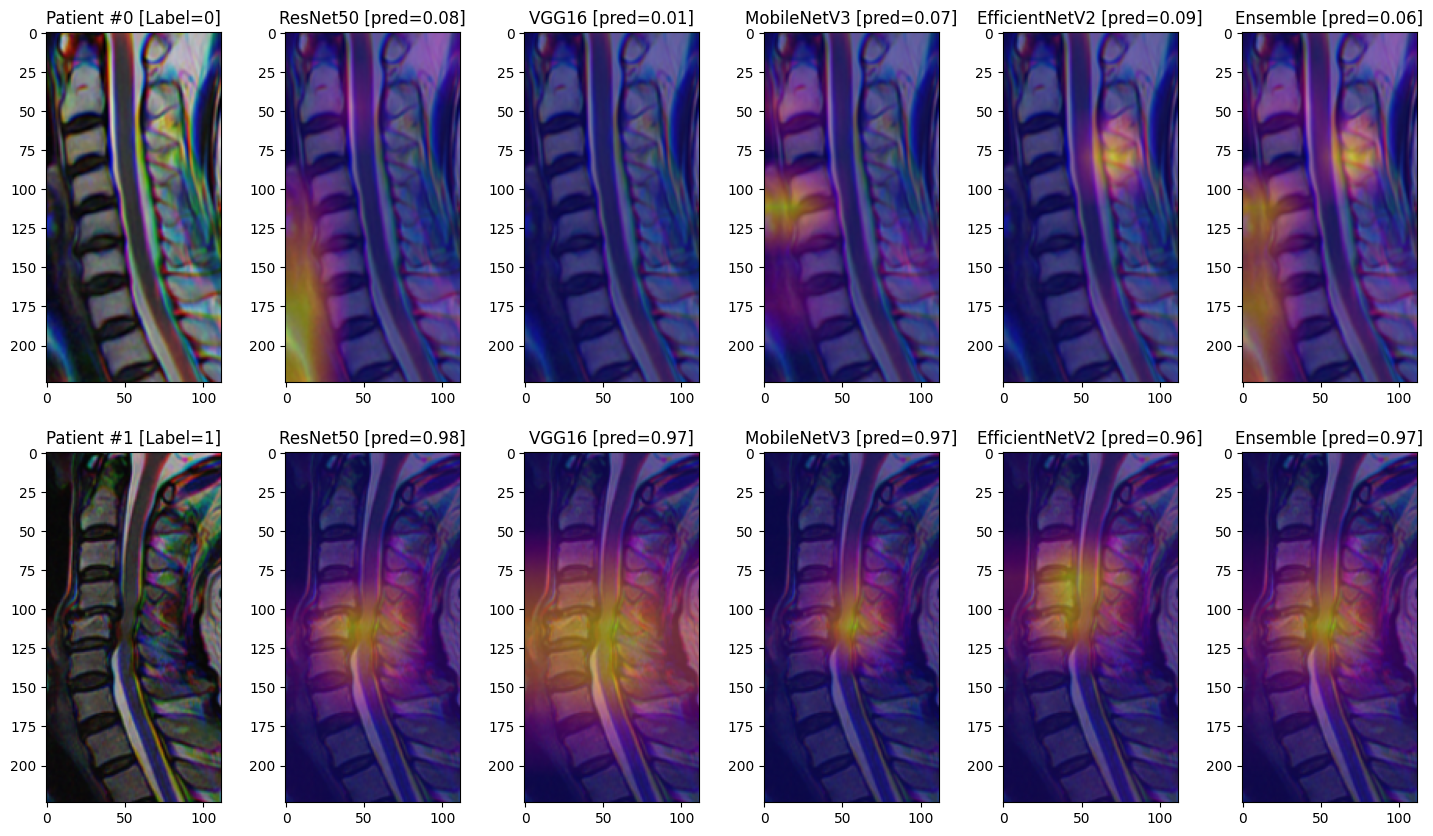

In [139]:
image_list, label_list = [], []

for pid in df_demo.index:
    print(f'>> Processing Patient #{pid}...')
    heatmap_ensemble, out_ensemble = None, 0
    
    image = X_test[pid]
    image = preprocess_image(image[tf.newaxis, ...])

    image_list.append(image.numpy().astype(np.uint8))
    label_list.append(f'Patient #{pid} [Label={df_demo.loc[pid, "label"]}]')

    for arch in ARCH_LIST:
        heatmap, out = None, 0
        model, last_conv_name = load_model(arch, return_last_conv=True)
        
        for i_fold in range(3):
            model.load_weights(f'model/{arch}/weights_{i_fold}.hdf5')
            heatmap_, out_ = make_gradcam_heatmap(image, model, last_conv_name)
            
            try: heatmap += heatmap_
            except: heatmap = heatmap_

            out += sigmoid(out_[0][0]) / 3

        heatmap = cv2.resize(heatmap, (112, 224))
        try: heatmap_ensemble += heatmap
        except: heatmap_ensemble = heatmap

        out_ensemble += out / len(ARCH_LIST)
        overlap_image = overlap_image_heatmap(image, heatmap, cmap='plasma', alpha=1)

        image_list.append(overlap_image)
        label_list.append(f'{arch} [pred={out:.2f}]')

    overlap_image_ensemble = overlap_image_heatmap(image, heatmap_ensemble, cmap='plasma', alpha=1)
    image_list.append(overlap_image_ensemble)
    label_list.append(f'Ensemble [pred={out_ensemble:.2f}]')

    print()

image_list = [np.squeeze(image) for image in image_list]
ShowImages(image_list, label_list, ncols=6, figsize=(3, 5))